In [1]:
# Import main Librarie
import tensorflow as tf
import tensorflow_datasets as tfds

In [4]:
# Download the data, save them as `tfrecord` files, load the `tfrecord` files
# and create the `tf.data.Dataset` object containing the dataset.
ratings_dataset, ratings_dataset_info = tfds.load(
    name='movielens/100k-ratings',
    # MovieLens dataset is not splitted into `train` and `test` sets by default.
    # So TFDS has put it all into `train` split. We load it completely and split
    # it manually.
    split='train',
    # `with_info=True` makes the `load` function return a `tfds.core.DatasetInfo`
    # object containing dataset metadata like version, description, homepage,
    # citation, etc.
    with_info=True
)

# Calling the `tfds.load()` function in old versions of TFDS won't return an
# instance of `tf.data.Dataset` type. So we can make sure about it.
import tensorflow as tf
assert isinstance(ratings_dataset, tf.data.Dataset)

print(
    "ratings_dataset size: %d" % ratings_dataset.__len__()
)

# Use `tfds.as_dataframe()` to convert `tf.data.Dataset` to `pandas.DataFrame`.
# Add the `tfds.core.DatasetInfo` as second argument of `tfds.as_dataframe` to
# visualize images, audio, texts, videos, etc. `pandas.DataFrame` will load the
# full dataset in-memory, and can be very expensive to display. So use it only
# with take() function.
print(
    tfds.as_dataframe(ratings_dataset.take(5), ratings_dataset_info)
)

## Feature selection
ratings_dataset = ratings_dataset.map(
    lambda rating: {
        # `user_id` is useful as a user identifier.
        'user_id': rating['user_id'],
        # `movie_id` is useful as a movie identifier.
        'movie_id': rating['movie_id'],
        # `movie_title` is useful as a textual information about the movie.
        'movie_title': rating['movie_title'],
        # `user_rating` shows the user's level of interest to a movie.
        'user_rating': rating['user_rating'],
        # `timestamp` will allow us to model the effect of time.
        'timestamp': rating['timestamp']
    }
)

print(
    tfds.as_dataframe(ratings_dataset.take(5), ratings_dataset_info)
)

## Split dataset randomly (80% for train and 20% for test)
trainset_size = 0.8 * ratings_dataset.__len__().numpy()
# In an industrial recommender system, this would most likely be done by time:
# The data up to time T would be used to predict interactions after T.

# set the global seed:
tf.random.set_seed(42)
# More info: https://www.tensorflow.org/api_docs/python/tf/random/set_seed

# Shuffle the elements of the dataset randomly.
ratings_dataset_shuffled = ratings_dataset.shuffle(
    # the new dataset will be sampled from a buffer window of first `buffer_size`
    # elements of the dataset
    buffer_size=100_000,
    # set the random seed that will be used to create the distribution.
    seed=42,
    # `list(dataset.as_numpy_iterator()` yields different result for each call
    # Because reshuffle_each_iteration defaults to True.
    reshuffle_each_iteration=False
)
# More info: https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle

ratings_trainset = ratings_dataset_shuffled.take(trainset_size)
ratings_testset = ratings_dataset_shuffled.skip(trainset_size)

print(
    "ratings_trainset size: %d" % ratings_trainset.__len__()
)
print(
    "ratings_testset size: %d" % ratings_testset.__len__()
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-ratings/0.1.1.incompleteIWI383/movielens-train.tfrecord*...…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.1. Subsequent calls will reuse this data.
ratings_dataset size: 100000
   bucketized_user_age movie_genres movie_id  \
0                 45.0          [7]   b'357'   
1                 25.0      [4, 14]   b'709'   
2                 18.0          [4]   b'412'   
3                 50.0       [5, 7]    b'56'   
4                 50.0     [10, 16]   b'895'   

                                 movie_title  raw_user_age  timestamp  \
0  b"One Flew Over the Cuckoo's Nest (1975)"          46.0  879024327   
1                b'Strictly Ballroom (1992)'          32.0  875654590   
2             b'Very Brady Sequel, A (1996)'          24.0  882075110   
3                     b'Pulp Fiction (1994)'          50.0  883326919   
4                         b'Scream 2 (1997)'          55.0  891409199   

   user_gender user_id  user_occupation_label user_occupation_text  \
0         True  b'138'           

## Process raw features and make embedding with Keras preprocessing

In [6]:
from pprint import pprint

for rating in ratings_trainset.take(1).as_numpy_iterator():
  pprint(rating)

{'movie_id': b'898',
 'movie_title': b'Postman, The (1997)',
 'timestamp': 885409515,
 'user_id': b'681',
 'user_rating': 4.0}


### Normalize numerical feature

In [7]:
# make keras Normalization layer to standarize a numerical feature.
timestamp_normalization_layer = \
    tf.keras.layers.experimental.preprocessing.Normalization(axis=None)

# Normalization layer is a non-trainable layer and its state (mean and std of
# feature set) must be set before training in a step called "adaptation".
timestamp_normalization_layer.adapt(
    ratings_trainset.map(
        lambda x: x['timestamp']
    )
)

for rating in ratings_trainset.take(3).as_numpy_iterator():
  print(
      f"Raw timestamp: {rating['timestamp']} ->",
      f"Normalized timestamp: {timestamp_normalization_layer(rating['timestamp'])}"
  )

Raw timestamp: 885409515 -> Normalized timestamp: 0.3537561595439911
Raw timestamp: 883388887 -> Normalized timestamp: -0.02487170137465
Raw timestamp: 891249586 -> Normalized timestamp: 1.4480509757995605


### Turning categorical features into embeddings

In [8]:
# Make a Keras StringLookup layer as the mapping (lookup)
user_id_lookup_layer = \
    tf.keras.layers.experimental.preprocessing.StringLookup(mask_token=None)

# StringLookup layer is a non-trainable layer and its state (the vocabulary)
# must be constructed and set before training in a step called "adaptation".
user_id_lookup_layer.adapt(
    ratings_trainset.map(
        lambda x: x['user_id']
    )
)

print(
    f"Vocabulary[:10] -> {user_id_lookup_layer.get_vocabulary()[:10]}"
    # Vocabulary: ['[UNK]', '405', '655', '13', ...]
    # The vocabulary includes one (or more!) unknown (or "out of vocabulary", OOV)
    # tokens. So the layer can handle categorical values that are not in the
    # vocabulary and the model can continue to learn about and make
    # recommendations even using features that have not been seen during
    # vocabulary construction.
)

print(
    "Mapped integer for user ids: ['-2', '13', '655', 'xxx']\n",
    user_id_lookup_layer(
        ['-2', '13', '655', 'xxx']
    )
)

user_id_embedding_dim = 32
# The larger it is, the higher the capacity of the model, but the slower it is
# to fit and serve and more prone to overfitting.

user_id_embedding_layer = tf.keras.layers.Embedding(
    # Size of the vocabulary
    input_dim=user_id_lookup_layer.vocab_size(),
    # Dimension of the dense embedding
    output_dim=user_id_embedding_dim
)

# A model that takes raw string feature values (user_id) in and yields embeddings
user_id_model = tf.keras.Sequential(
    [
        user_id_lookup_layer,
        user_id_embedding_layer
    ]
)

print(
    "Embeddings for user ids: ['-2', '13', '655', 'xxx']\n",
    user_id_model(
        ['-2', '13', '655', 'xxx']
    )
)


movie_id_lookup_layer = \
    tf.keras.layers.experimental.preprocessing.StringLookup(mask_token=None)
movie_id_lookup_layer.adapt(
    ratings_trainset.map(
        lambda x: x['movie_id']
    )
)

# Same as user_id_embedding_dim to be able to measure the similarity
movie_id_embedding_dim = 32

movie_id_embedding_layer = tf.keras.layers.Embedding(
    input_dim=movie_id_lookup_layer.vocab_size(),
    output_dim=movie_id_embedding_dim
)

movie_id_model = tf.keras.Sequential(
    [
        movie_id_lookup_layer,
        movie_id_embedding_layer
    ]
)

print(
    f"Embedding for the movie 898:\n {movie_id_model('898')}"
)

Vocabulary[:10] -> ['[UNK]', '405', '655', '13', '450', '276', '303', '416', '537', '234']
Mapped integer for user ids: ['-2', '13', '655', 'xxx']
 tf.Tensor([0 3 2 0], shape=(4,), dtype=int64)
Embeddings for user ids: ['-2', '13', '655', 'xxx']
 tf.Tensor(
[[-0.00813343  0.02842431 -0.00398662  0.01395911 -0.01975018 -0.0155059
  -0.04305618 -0.02939802 -0.02056915 -0.04328452  0.02602403 -0.02263566
   0.02480525 -0.01939564  0.00103943 -0.00850228 -0.02453213 -0.000378
   0.01716621 -0.02288844  0.01604546  0.00477275 -0.02213638  0.00692549
   0.0400009   0.03565795 -0.01948324  0.02915701  0.01004168  0.04872695
  -0.03034922 -0.00574392]
 [-0.03312369 -0.0025452  -0.04646671 -0.01466925  0.02780728  0.02199695
   0.0176916   0.02584041 -0.02674486 -0.02574576 -0.01812803 -0.00044985
  -0.02288325  0.04176557 -0.03149674  0.04740155  0.02829787 -0.00841837
   0.00518464 -0.01736277 -0.02719598  0.04667581 -0.00409102  0.00668694
   0.00597817  0.01414727 -0.009645   -0.00545249  0

Embedding for the movie 898:
 [ 0.02880022  0.03797432  0.02671721  0.0447516   0.01605723 -0.02229626
  0.00625893 -0.015721    0.00687762 -0.04870243  0.03207767 -0.02751886
 -0.01482434  0.00928353  0.03533328  0.00183749 -0.03063982 -0.04072112
 -0.02849861  0.00463784  0.03150909 -0.03246894  0.01786376  0.03528381
  0.02394005  0.00845498 -0.04319018 -0.00716309 -0.04571288 -0.04557288
  0.04769348  0.00573621]


### Tokenize textual features and translate them into embeddings

In [9]:
# map these pieces into tokens.
movie_title_vectorization_layer = \
    tf.keras.layers.experimental.preprocessing.TextVectorization()
movie_title_vectorization_layer.adapt(
    ratings_trainset.map(
        lambda rating: rating['movie_title']
    )
)

# Verify that the tokenization is done correctly
print(
    "Vocabulary[40:50] -> ",
    movie_title_vectorization_layer.get_vocabulary()[40:50]
)

print(
    "Vectorized title for 'Postman, The (1997)'\n",
    movie_title_vectorization_layer('Postman, The (1997)')
)

movie_title_embedding_dim = 32
movie_title_embedding_layer = tf.keras.layers.Embedding(
    input_dim=len(movie_title_vectorization_layer.get_vocabulary()),
    output_dim=movie_title_embedding_dim,
    # Whether or not the input value 0 is a MASK token.
    # Keras TextVectorization layer builds the vocabulary with MASK token.
    mask_zero=True
)

movie_title_model = tf.keras.Sequential(
    [
       movie_title_vectorization_layer,
       movie_title_embedding_layer,
       # each title contains multiple words, so we will get multiple embeddings
       # for each title that should be compressed into a single embedding for
       # the text. Models like RNNs, Transformers or Attentions are useful here.
       # However, averaging all the words' embeddings together is also a good
       # starting point.
       tf.keras.layers.GlobalAveragePooling1D()
    ]
)

Vocabulary[40:50] ->  ['first', 'contact', '1971', '1977', 'monty', '1983', 'love', 'on', 'last', 'men']
Vectorized title for 'Postman, The (1997)'
 tf.Tensor([1120    2    4], shape=(3,), dtype=int64)


### Query and Candidate representation

In [10]:
# Query tower
query_model = user_id_model

# Candidate tower
candidate_model = movie_id_model

### Build the Retrieval (Candidate Generation) task

In [11]:
# We don't need rating field for the retrieval task
retrieval_ratings_trainset = ratings_trainset.map(
    lambda rating: {
        'user_id': rating['user_id'],
        'movie_id': rating['movie_id'],
    }
)

retrieval_ratings_testset = ratings_testset.map(
    lambda rating: {
        'user_id': rating['user_id'],
        'movie_id': rating['movie_id'],
    }
)

In [12]:
# all possible candidates that are used as implicit negatives for evaluation.
movies_dataset, movies_dataset_info = tfds.load(
    name='movielens/100k-movies',
    split='train',
    with_info=True
)

print(
    tfds.as_dataframe(movies_dataset.take(5), movies_dataset_info)
)

# We are using just `movie_id` feature for making the candidates representation
candidates_corpus_dataset = movies_dataset.map(
    lambda movie: movie['movie_id']
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1682 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-movies/0.1.1.incomplete6DHIAT/movielens-train.tfrecord*...:…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-movies/0.1.1. Subsequent calls will reuse this data.
  movie_genres movie_id                      movie_title
0          [4]  b'1681'           b'You So Crazy (1994)'
1       [4, 7]  b'1457'   b'Love Is All There Is (1996)'
2       [1, 3]   b'500'          b'Fly Away Home (1996)'
3          [0]   b'838'  b'In the Line of Duty 2 (1987)'
4          [7]  b'1648'       b'Niagara, Niagara (1997)'


In [13]:
!pip install -q scann tensorflow-recommenders
# We also installed `ScaNN` package as a dependency for TFRS library
# We will describe ScaNN in future but it has to be installed before importing
# the TFRS
import tensorflow_recommenders as tfrs

factorized_top_k_metrics = tfrs.metrics.FactorizedTopK(
    # dataset of candidate embeddings from which candidates should be retrieved
    candidates=candidates_corpus_dataset.batch(128).map(
        candidate_model
    )
)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 8.6 MB/s eta 0:00:00


In [14]:
retrieval_task_layer = tfrs.tasks.Retrieval(
    metrics=factorized_top_k_metrics
)

### Create the training loop

In [15]:
class RetrievalModel(tfrs.models.Model):
  """MovieLens candidate generation model"""

  def __init__(self, query_model, candidate_model, retrieval_task_layer):
    super().__init__()
    self.query_model: tf.keras.Model = query_model
    self.candidate_model: tf.keras.Model = candidate_model
    self.retrieval_task_layer: tf.keras.layers.Layer = retrieval_task_layer

 #def compute_loss(self, features: Dict[Text, tf.Tensor], training=False):
  def compute_loss(self, features, training=False) -> tf.Tensor:
    query_embeddings = self.query_model(features['user_id'])
    positive_candidate_embeddings = self.candidate_model(features["movie_id"])

    loss = self.retrieval_task_layer(
        query_embeddings,
        positive_candidate_embeddings
        # ,compute_metrics=not training  # To speed up training
    )
    return loss

### Fit the model using standard Keras routine


In [16]:
movielens_retrieval_model = RetrievalModel(
    query_model,
    candidate_model,
    retrieval_task_layer
)

optimizer_step_size = 0.1
movielens_retrieval_model.compile(
    optimizer=tf.keras.optimizers.Adagrad(
        learning_rate=optimizer_step_size
    )
)


In [17]:
# cached data.
retrieval_cached_ratings_trainset = \
  retrieval_ratings_trainset.shuffle(100_000).batch(8192).cache()
retrieval_cached_ratings_testset = \
  retrieval_ratings_testset.batch(4096).cache()

num_epochs = 5
history = movielens_retrieval_model.fit(
    retrieval_cached_ratings_trainset,
    validation_data=retrieval_cached_ratings_testset,
    validation_freq=1,
    epochs=num_epochs
)

Epoch 1/5
10/10 [==============================] - 80s 7s/step - factorized_top_k/top_1_categorical_accuracy: 9.0000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0083 - factorized_top_k/top_10_categorical_accuracy: 0.0192 - factorized_top_k/top_50_categorical_accuracy: 0.0970 - factorized_top_k/top_100_categorical_accuracy: 0.1744 - loss: 69832.2180 - regularization_loss: 0.0000e+00 - total_loss: 69832.2180 - val_factorized_top_k/top_1_categorical_accuracy: 0.0024 - val_factorized_top_k/top_5_categorical_accuracy: 0.0140 - val_factorized_top_k/top_10_categorical_accuracy: 0.0281 - val_factorized_top_k/top_50_categorical_accuracy: 0.1514 - val_factorized_top_k/top_100_categorical_accuracy: 0.2637 - val_loss: 28819.3164 - val_regularization_loss: 0.0000e+00 - val_total_loss: 28819.3164
Epoch 2/5
10/10 [==============================] - 44s 4s/step - factorized_top_k/top_1_categorical_accuracy: 0.0027 - factorized_top_k/top_5_categorical_accuracy: 0.0188 - factorized_top_k/top_10_

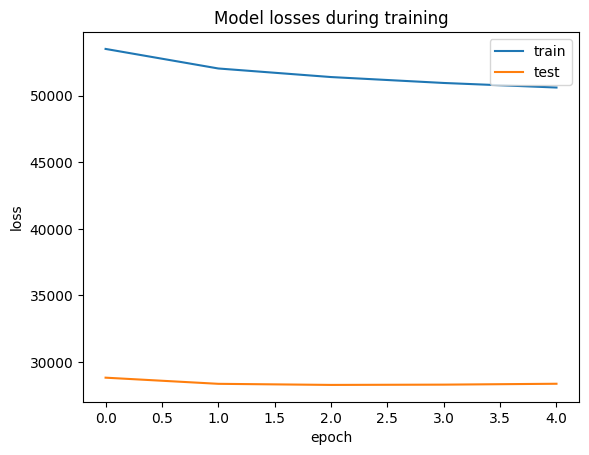

In [18]:
# Plot changes in model loss during training
import matplotlib.pyplot as plt

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model losses during training")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "test"], loc="upper right")
plt.show()

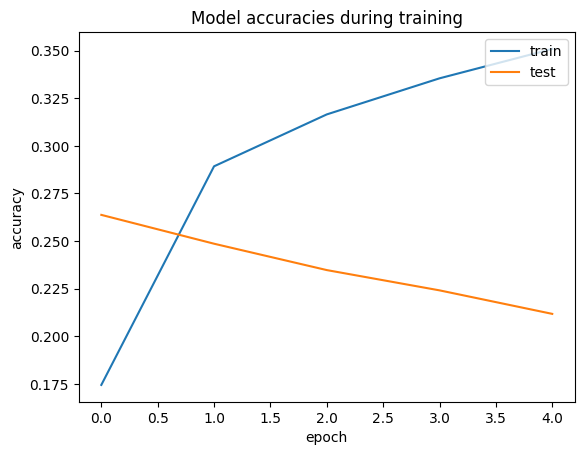

In [19]:
# Plot changes in model accuracy during training
plt.plot(history.history["factorized_top_k/top_100_categorical_accuracy"])
plt.plot(history.history["val_factorized_top_k/top_100_categorical_accuracy"])
plt.title("Model accuracies during training")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["train", "test"], loc="upper right")
plt.show()

### Making predictions


In [21]:
brute_force_layer = tfrs.layers.factorized_top_k.BruteForce(
    movielens_retrieval_model.query_model
)

brute_force_layer.index_from_dataset(
  tf.data.Dataset.zip(
      (
          candidates_corpus_dataset.batch(100),
          candidates_corpus_dataset.batch(100).map(
              movielens_retrieval_model.candidate_model
          )
      )
  )
)

In [22]:
user_id = '42'
afinity_scores, movie_ids = brute_force_layer(
    tf.constant([user_id])
)

print(f"Recommendations for user {user_id} using BruteForce: {movie_ids[0, :5]}")


Recommendations for user 42 using BruteForce: [b'1043' b'225' b'220' b'934' b'468']


In [23]:
scann_layer = tfrs.layers.factorized_top_k.ScaNN(
    movielens_retrieval_model.query_model
)

scann_layer.index_from_dataset(
  tf.data.Dataset.zip(
      (
          candidates_corpus_dataset.batch(100),
          candidates_corpus_dataset.batch(100).map(
              movielens_retrieval_model.candidate_model
          )
      )
  )
)

user_id = '42'
afinity_scores, movie_ids = scann_layer(
    tf.constant([user_id])
)

print(f"Recommendations for user {user_id} using ScaNN: {movie_ids[0, :5]}")


Recommendations for user 42 using ScaNN: [b'220' b'73' b'756' b'623' b'1051']


### Save the model to use in future

In [25]:
import os
import tempfile

with tempfile.TemporaryDirectory() as tmp_dir:
  retrieval_model_path = os.path.join(tmp_dir, "retrieval_model")


scann_layer.save(
    retrieval_model_path,
    options=tf.saved_model.SaveOptions(namespace_whitelist=["Scann"])
)

### Build the Ranking (Scoring) task

In [27]:
class RankingModel(tfrs.models.Model):
  """MovieLens ranking model"""

  def __init__(self, query_model, candidate_model):
    super().__init__()

    self.query_model: tf.keras.Model = query_model
    self.candidate_model: tf.keras.Model = candidate_model
    self.rating_model = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(1)
        ]
    )
    self.ranking_task_layer: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[
            tf.keras.metrics.RootMeanSquaredError()
        ]
    )


  def compute_loss(self, features, training=False) -> tf.Tensor:
    query_embeddings = self.query_model(features['user_id'])
    candidate_embeddings = self.candidate_model(features["movie_id"])
    rating_predictions = self.rating_model(
        tf.concat(
            [query_embeddings, candidate_embeddings],
            axis=1
        )
        # We could use `tf.keras.layers.Concatenate(axis=1)([x, y])`
    )

    loss = self.ranking_task_layer(
        predictions=rating_predictions,
        labels=features["user_rating"]
    )
    return loss

### Fit the ranking model

In [28]:
movielens_ranking_model = RankingModel(query_model, candidate_model)

optimizer_step_size = 0.1
movielens_ranking_model.compile(
    optimizer=tf.keras.optimizers.Adagrad(
        learning_rate=optimizer_step_size
    )
)

In [29]:
ranking_ratings_trainset = ratings_trainset.shuffle(100_000).batch(8192).cache()
ranking_ratings_testset = ratings_testset.batch(4096).cache()

history = movielens_ranking_model.fit(
    ranking_ratings_trainset,
    validation_data=ranking_ratings_testset,
    validation_freq=1,
    epochs=5
)

Epoch 1/5
10/10 [==============================] - 12s 651ms/step - root_mean_squared_error: 2.0088 - loss: 3.8534 - regularization_loss: 0.0000e+00 - total_loss: 3.8534 - val_root_mean_squared_error: 1.2238 - val_loss: 1.4569 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.4569
Epoch 2/5
10/10 [==============================] - 1s 141ms/step - root_mean_squared_error: 1.2040 - loss: 1.4251 - regularization_loss: 0.0000e+00 - total_loss: 1.4251 - val_root_mean_squared_error: 1.0736 - val_loss: 1.1234 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.1234
Epoch 3/5
10/10 [==============================] - 0s 49ms/step - root_mean_squared_error: 1.0633 - loss: 1.1211 - regularization_loss: 0.0000e+00 - total_loss: 1.1211 - val_root_mean_squared_error: 1.0204 - val_loss: 1.0168 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.0168
Epoch 4/5
10/10 [==============================] - 1s 66ms/step - root_mean_squared_error: 1.0213 - loss: 1.0377 - regularization_los

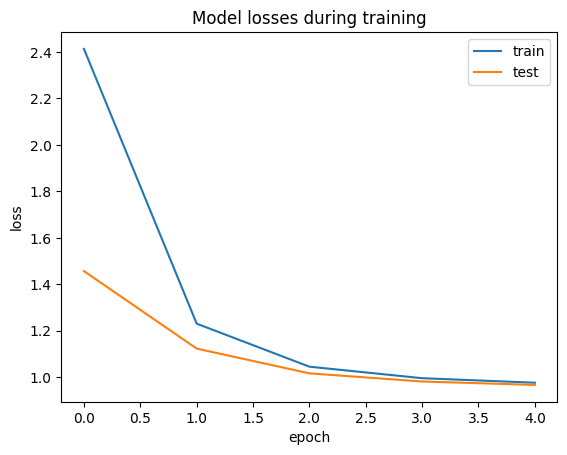

In [30]:
# Plot changes in model loss during training
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model losses during training")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "test"], loc="upper right")
plt.show()